<img src='http://imgur.com/1ZcRyrc.png' style='float: left; margin: 20px; height: 55px'>

# Project 4a: West Nile Virus

## Part 3 - Modelling

---
## Contents
---

### [Part 1 - Data Cleaning](part_1.ipynb)
1. Background on West Nile Virus
2. Imports
3. Trap Data
4. Weather Data
5. Spray Data

### [Part 2 - Exploratory Data Analysis (EDA)](part_2.ipynb)
1. Imports
2. Exploratory Data Analysis - Trends
3. Trends in Mosquito Trapping
4. Detection of WNV+ in Traps
5. Detection of WNV+ in Mosquito Species
6. Detection of WNV+ Hotspots
7. Trends in Weather
8. Impact of Spraying on Number of Mosquitos

### [Part 3 - Modelling](part_3.ipynb)
1. [Pre-processing](#1.-Pre-processing)
2. [Modelling](#2.-Modelling)
3. [Kaggle Submission](#3.-Kaggle-Submission)
4. [Conclusion](#4.-Conclusion)

---
## 1. Pre-processing
---

### 1a. Import Libraries

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np

# Import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Import modelling libraries
import lazypredict
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
import pickle


/Users/m.farhanrais/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1b. Import Data
Import the cleaned data from previous notebooks.

In [2]:
# Import train_df.csv from previous notebook
train_df = pd.read_csv('../data/train_clean.csv')

# Import test.csv from previous notebook
test_df = pd.read_csv('../data/test_clean.csv')

# Import weather_df.csv from previous notebook
weather_df = pd.read_csv('../data/weather_clean.csv')

# Import weather_df.csv from previous notebook
spray_df = pd.read_csv('../data/spray_clean.csv')

In [3]:
# Display dataframes
print("train_df")
display(train_df.head())

print("test_df")
display(test_df.head())

print("weather_df")
display(weather_df.head())

print("spray_df")
display(spray_df.head())

train_df


,date,address,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,year_month,erraticus,pipiens,restuans,salinarius,tarsalis,territans
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",T002,41.95,-87.80,1,0,2007,5,2007-05,0,1,1,0,0,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",T002,41.95,-87.80,1,0,2007,5,2007-05,0,0,1,0,0,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",T007,41.99,-87.77,1,0,2007,5,2007-05,0,0,1,0,0,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",T015,41.97,-87.82,1,0,2007,5,2007-05,0,1,1,0,0,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",T015,41.97,-87.82,4,0,2007,5,2007-05,0,0,1,0,0,0


test_df


,id,date,trap,latitude,longitude,erraticus,pipiens,restuans,salinarius,tarsalis,territans
0,1,2008-06-11,T002,41.95,-87.80,0,1,1,0,0,0
1,2,2008-06-11,T002,41.95,-87.80,0,0,1,0,0,0
2,3,2008-06-11,T002,41.95,-87.80,0,1,0,0,0,0
3,4,2008-06-11,T002,41.95,-87.80,0,0,0,1,0,0
4,5,2008-06-11,T002,41.95,-87.80,0,0,0,0,0,1


weather_df


,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,year_month
0,2007-05-01,83,50,67.00,14.00,51,56.00,0.00,2.00,448,...,0.00,0.00,29.10,29.82,1.70,27,9.20,2007,5,2007-05
1,2007-05-02,59,42,51.00,-3.00,42,47.00,14.00,0.00,447,...,0.00,0.00,29.38,30.09,13.00,4,13.40,2007,5,2007-05
2,2007-05-03,66,46,56.00,2.00,40,48.00,9.00,0.00,446,...,0.00,0.00,29.39,30.12,11.70,7,11.90,2007,5,2007-05
3,2007-05-04,66,49,58.00,4.00,41,50.00,7.00,0.00,444,...,0.00,0.01,29.31,30.05,10.40,8,10.80,2007,5,2007-05
4,2007-05-05,66,53,60.00,5.00,38,49.00,5.00,0.00,443,...,0.00,0.01,29.40,30.10,11.70,7,12.00,2007,5,2007-05


spray_df


,date,latitude,longitude,year,month,year_month
0,2011-08-29,42.39,-88.09,2011,8,2011-08
1,2011-08-29,42.39,-88.09,2011,8,2011-08
2,2011-08-29,42.39,-88.09,2011,8,2011-08
3,2011-08-29,42.39,-88.09,2011,8,2011-08
4,2011-08-29,42.39,-88.09,2011,8,2011-08


### 1c. Drop Columns

In [4]:
# First drop
drop_list1 = ['erraticus', 'tarsalis', 'salinarius']
train_df.drop(columns=drop_list1, inplace=True)
test_df.drop(columns=drop_list1, inplace=True)

In [5]:
# Second drop
drop_list2 = ['snowfall', 'depth']
weather_df.drop(columns=drop_list2, inplace=True)

### 1c. Pre-processing data before modeling

In [6]:
# Merge train_df and weather_df dataframes by 'date' column, without duplicated columns
df = pd.merge(train_df, weather_df, on='date').drop_duplicates()
df.shape

(9693, 33)

In [7]:
# Drop all columns with data type 'object'
df = df.drop(columns=df.select_dtypes('object').columns)
df.shape

(9693, 27)

In [48]:
df.head()

,latitude,longitude,nummosquitos,wnvpresent,year_x,month_x,pipiens,restuans,territans,tmax,...,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year_y,month_y
0,41.955,-87.801,1,0,2007,5,1,1,0,88,...,421,1917,0.000,29.390,30.110,5.800,18,6.500,2007,5
1,41.955,-87.801,1,0,2007,5,0,1,0,88,...,421,1917,0.000,29.390,30.110,5.800,18,6.500,2007,5
2,41.995,-87.769,1,0,2007,5,0,1,0,88,...,421,1917,0.000,29.390,30.110,5.800,18,6.500,2007,5
3,41.974,-87.825,1,0,2007,5,1,1,0,88,...,421,1917,0.000,29.390,30.110,5.800,18,6.500,2007,5
4,41.974,-87.825,4,0,2007,5,0,1,0,88,...,421,1917,0.000,29.390,30.110,5.800,18,6.500,2007,5


### 1d. Train-Test-Split
All subsequent modelling steps will use the same train-test-split data.

In [8]:
# Assemble X and y features
X = df.drop(columns=['wnvpresent'])
y = df['wnvpresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 1e. Handling Imbalanced Classes

In [9]:
# Check the proportion of 2 classes in y
y_counts = y.value_counts()
y_counts

0    9190
1     503
Name: wnvpresent, dtype: int64

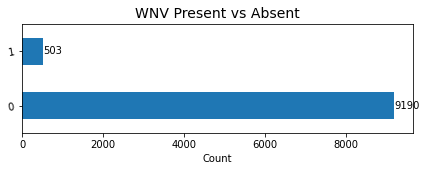

In [10]:
# Plot a horizontal bar graph to visualize the count
ax = y_counts.plot(kind='barh', figsize=(7,2))
plt.title('WNV Present vs Absent', fontsize=14)
plt.xlabel('Count', fontsize=10)
ax.set_yticklabels(y_counts.index, rotation=10)

for i, v in enumerate(y_counts):
    ax.text(v + 10, i, str(v), color='black', fontsize=10, va='center')

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem.
It aims to balance class distribution by randomly increasing minority class examples by replicating them.

In [11]:
# Apply SMOTE to train data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(13788, 26)
(13788,)


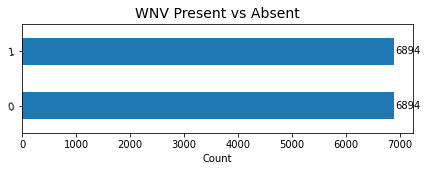

In [12]:
# Class size after applying SMOTE
y_train_resampled_counts = y_train_resampled.value_counts()
ax = y_train_resampled_counts.plot(kind='barh', figsize=(7,2))
plt.title('WNV Present vs Absent', fontsize=14)
plt.xlabel('Count', fontsize=10)
ax.set_yticklabels(y_counts.index, rotation=10)

for i, v in enumerate(y_train_resampled_counts):
    ax.text(v + 10, i, str(v), color='black', fontsize=10, va='center')

---
## 2. Modelling
---

### 2a. Lazy Predict

To quickly decide on a model, the Lazy Predict library is used to build 25 basic models.
From that library, the LazyClassifier is used as the model is aimed to classify the presence of WNV.


In [13]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display dataframe values to 3 decimal figures
pd.options.display.float_format = '{:.3f}'.format
models.sort_values(by='Accuracy', ascending=False)


100%|██████████| 29/29 [00:06<00:00,  4.76it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.947,0.500,0.500,0.922,0.618
SGDClassifier,0.947,0.500,0.500,0.922,0.030
RidgeClassifierCV,0.947,0.500,0.500,0.922,0.030
DummyClassifier,0.947,0.500,0.500,0.922,0.008
LinearSVC,0.947,0.500,0.500,0.922,0.214
CalibratedClassifierCV,0.947,0.522,0.522,0.926,0.862
LogisticRegression,0.947,0.526,0.526,0.926,0.062
AdaBoostClassifier,0.945,0.539,0.539,0.928,0.246
PassiveAggressiveClassifier,0.943,0.505,0.505,0.921,0.015


While `XSBoost Classifier` is the 2nd most accurate, the difference with the most accurate model (`LinearSVC`) is marginal (0.001) with run time almost 10 times faster. Hence it is the chosen model.

### 2b. XGBoost Classifier

Through the use of pipelines, scaling will be done using `StandardScaler` and imbalanced classes will be handled by `SMOTE`.

In [14]:
pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTE()),
    ('xgb', XGBClassifier())
])

In [15]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sampling', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi

In [16]:
pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTE()),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=None, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...))],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTE(),
 'xgb': XGBClassifier(base_score=None, booster=None

In [17]:
# To minimise run time, the original hyperparameter from GridSearch are included as comments.

pipe_params = {
    'xgb__n_estimators': [200], #[50, 100, 200]
    'xgb__learning_rate': [0.5], #[0.01, 0.1, 0.5]
    'xgb__max_depth': [5], #[3, 5, 7]
    'xgb__subsample': [0.5, 0.8, 1.0], #[0.5, 0.8, 1.0]
    'xgb__colsample_bytree': [0.5], #[0.5, 0.8, 1.0]
    'xgb__random_state': [42]
}

In [18]:
pipe_gridsearch = GridSearchCV(pipe, pipe_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [19]:
pipe_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/m.farhanrais/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/m.farhanrais/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/m.farhanrais/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/m.farhanrais/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detecte

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_typ

In [20]:
# Print out best estimator.
pipe_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()), ('sampling', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_stra

In [21]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_gridsearch.best_score_

0.9269497913059448

In [22]:
# Evaluate the best model on the test data (accuracy score)
pipe_gridsearch.score(X_test, y_test)

0.9273927392739274

In [23]:
fitted_model = pipe_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on train data set: {auc_score_train}')
print(f'ROC-AUC on test data set: {auc_score_test}')
print()

# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on train data set: 0.99818025336041
ROC-AUC on test data set: 0.8607428680313589

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2296
           1       0.31      0.30      0.30       128

    accuracy                           0.93      2424
   macro avg       0.63      0.63      0.63      2424
weighted avg       0.93      0.93      0.93      2424



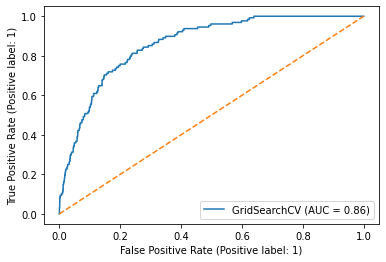

In [24]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

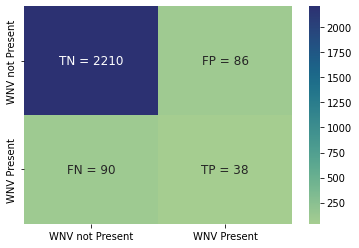

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [26]:
coef = fitted_model.best_estimator_['xgb'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: ylabel='Features'>

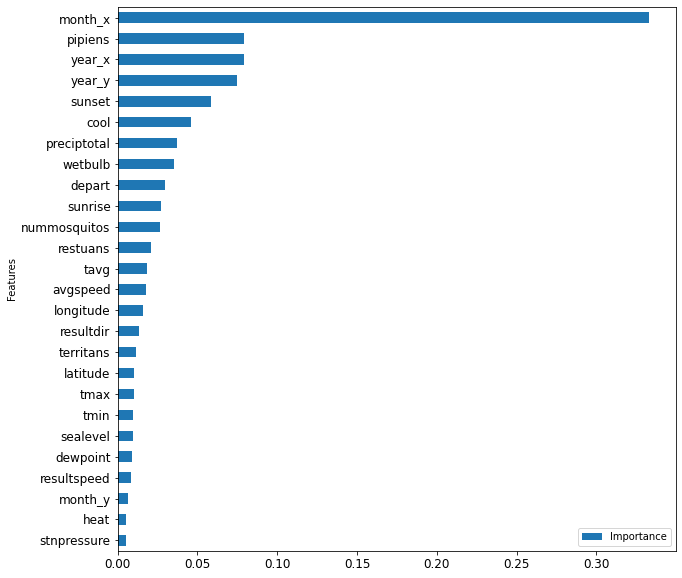

In [27]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 10 and bottom 10 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(0, 'Importance')

# Change axis label font size
plt.rcParams['xtick.labelsize'] = 12
# Change y axis label font size
plt.rcParams['ytick.labelsize'] = 12

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

# Plot only features that have importance greater than 0
selected_features[selected_features['Importance'] > 0].plot(kind='barh', x='Features', y='Importance', figsize=(10,10))


In [28]:
# List features that have importance of 0 as a list
zero_importance_features = selected_features[selected_features['Importance'] == 0]['Features'].to_list()
zero_importance_features

[]

The above generated the list of features below in a previous iteration and have been removed:

['erraticus', 'tarsalis', 'salinarius', 'snowfall', 'depth']

### 2c. Pickle Trained Model for Streamlit

In [29]:
# Save the trained model to the pickle file
with open('../data/xgb_model.pkl', 'wb') as model_file:
    pickle.dump(fitted_model, model_file)

---
## 3. Kaggle Submission
---

In [30]:
# Load the trained model from pickle file
with open('../data/xgb_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [36]:
# Merge test_df and weather_df dataframes by 'date' column
pred_df = pd.merge(test_df, weather_df, on='date')

pred_df.shape

(116293, 28)

In [37]:
# Drop all columns with data type 'object'
pred_df = pred_df.drop(columns=pred_df.select_dtypes('object').columns)
pred_df.shape

(116293, 24)

In [39]:
# Add missing columns to pred_df and set their values to 0
missing_cols = set(df.columns) - set(pred_df.columns)
# Keep only first 11 elements in missing_cols
missing_cols = list(set(df.columns) - set(pred_df.columns))[:2]

for col in missing_cols:
    pred_df[col] = 0

pred_df.shape

(116293, 26)

In [40]:
# Using the loaded model to predict the probability of WNV presence
pred_df['wnvpresent'] = loaded_model.predict_proba(pred_df)[:,1]

In [41]:
# Count the values in 'wnvpresent' column
pred_df['wnvpresent'].value_counts()

0.000    3204
0.000    3201
0.000    3197
0.000    3196
0.000    2169
         ... 
0.000     151
0.000     151
0.000      36
0.000       5
0.000       1
Name: wnvpresent, Length: 143, dtype: int64

In [44]:
pred_df.head()

,id,latitude,longitude,pipiens,restuans,territans,tmax,tmin,tavg,depart,...,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,nummosquitos,year_x,wnvpresent
0,1,41.955,-87.801,1,1,0,86,61,74.000,7.000,...,29.280,29.990,8.900,18,10.000,2008,6,0,0,0.000
1,2,41.955,-87.801,0,1,0,86,61,74.000,7.000,...,29.280,29.990,8.900,18,10.000,2008,6,0,0,0.000
2,3,41.955,-87.801,1,0,0,86,61,74.000,7.000,...,29.280,29.990,8.900,18,10.000,2008,6,0,0,0.000
3,4,41.955,-87.801,0,0,0,86,61,74.000,7.000,...,29.280,29.990,8.900,18,10.000,2008,6,0,0,0.000
4,5,41.955,-87.801,0,0,1,86,61,74.000,7.000,...,29.280,29.990,8.900,18,10.000,2008,6,0,0,0.000


In [47]:
# Create a dataframe with only 'Id' and 'WnvPresent' columns
kaggle_df = pred_df[['id','wnvpresent']]

kaggle_df = kaggle_df.drop_duplicates()

# Save the dataframe to csv file
kaggle_df.to_csv("../data/predicted_wnv.csv",index=False)

#### Kaggle Score

Private score: 0.44127

Public score: 0.44113

---
## 4. Conclusion
---

### 4a. Recommendations

#### WHEN

**Traps** Continue from May through Oct

**Spray** When traps hit 14% WNV-positive

#### WHERE

1. ORD Terminal 5, O'Hare International Airport
2. South Doty Avenue
3. 4100 North Oak Park Avenue
4. South Stony Island Avenue
5. 4600 Milwaukee Avenue
6. 8200 South Kostner Avenue
7. 2400 East 105th Street
8. 3600 North Pittsburgh Avenue
9. O’Hare Court, Bensenville
10. 7000 North Moselle Avenue


### 4b. Recommendations

---
[Back to top](#Contents) | [Part 1](part_1.ipynb) | [Part 2](part_2.ipynb) | [Part 3](part_3.ipynb)